In [11]:
import shap
import xgboost as xgb
import numpy as np
import pandas as pd

# Create synthetic data with known interactions
np.random.seed(42)
n_samples = 1000

# Features with interaction: x1 * x2 creates synergy
x1 = np.random.normal(0, 1, n_samples)
x2 = np.random.normal(0, 1, n_samples) 
x3 = np.random.normal(0, 1, n_samples)

# Target with interaction effect: x1 and x2 multiply their impact
y = 2*x1 + 3*x2 + 5*x1*x2 + 0.5*x3 + np.random.normal(0, 0.1, n_samples)

X = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

# Train model
model = xgb.XGBRegressor(random_state=42)
model.fit(X, y)

# Get both regular and interaction SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[:10])  # Individual contributions
shap_interaction = explainer.shap_interaction_values(X[:10])  # Pairwise interactions

print("Shape of regular SHAP values:", shap_values.shape)  # (10, 3)
print("Shape of interaction SHAP values:", shap_interaction.shape)  # (10, 3, 3)

Shape of regular SHAP values: (10, 3)
Shape of interaction SHAP values: (10, 3, 3)


In [12]:
# For one sample, examine the interaction matrix
sample_idx = 0
interaction_matrix = shap_interaction[sample_idx]

print("Interaction matrix for sample 0:")
print(pd.DataFrame(interaction_matrix, 
                   columns=['x1', 'x2', 'x3'], 
                   index=['x1', 'x2', 'x3']))

"""
Example output:
        x1      x2      x3
x1   [main_x1] [x1*x2]  [x1*x3]
x2   [x1*x2]  [main_x2] [x2*x3] 
x3   [x1*x3]  [x2*x3]  [main_x3]
"""

Interaction matrix for sample 0:
          x1        x2        x3
x1  1.474599  1.441996 -0.035887
x2  1.441997  4.186538 -0.022455
x3 -0.035887 -0.022455 -0.330980


'\nExample output:\n        x1      x2      x3\nx1   [main_x1] [x1*x2]  [x1*x3]\nx2   [x1*x2]  [main_x2] [x2*x3] \nx3   [x1*x3]  [x2*x3]  [main_x3]\n'

In [13]:
# Fix: Individual SHAP values and diagonal interaction values are different concepts
print("Individual SHAP for x1:", shap_values[0, 0])
print("Diagonal interaction for x1 (main effect only):", shap_interaction[0, 0, 0])

# The individual SHAP value includes both main effect AND all interaction effects involving x1
# To verify: individual_shap[i] = diagonal[i] + sum of all interactions involving feature i
x1_total_interactions = shap_interaction[0, 0, 1] + shap_interaction[0, 0, 2]  # x1's interactions with x2 and x3
reconstructed_shap_x1 = shap_interaction[0, 0, 0] + x1_total_interactions

print(f"Reconstructed SHAP for x1: {reconstructed_shap_x1:.6f}")
print(f"Difference: {abs(shap_values[0, 0] - reconstructed_shap_x1):.6f}")
print("Note: Small differences are normal due to numerical precision")

Individual SHAP for x1: 2.8807077
Diagonal interaction for x1 (main effect only): 1.4745986
Reconstructed SHAP for x1: 2.880708
Difference: 0.000000
Note: Small differences are normal due to numerical precision


In [14]:
# Interaction between x1 and x2
x1_x2_interaction = shap_interaction[0, 0, 1]  # or [0, 1, 0] - they're symmetric
print(f"x1-x2 interaction effect: {x1_x2_interaction:.4f}")

x1-x2 interaction effect: 1.4420


/var/folders/zs/q57jlw697vzcd20zv4v890wm0000gn/T/ipykernel_95875/4265702001.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X[:n_samples_for_plot], max_display=10)


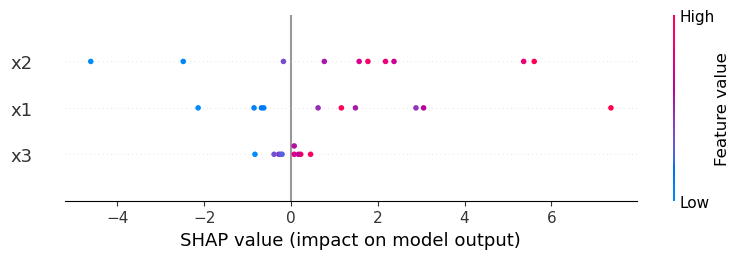

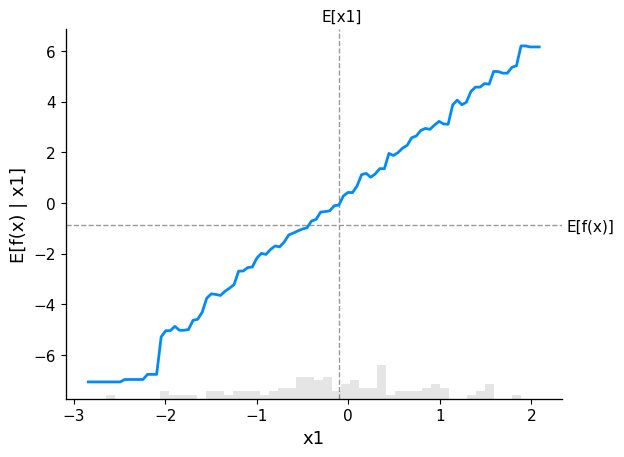

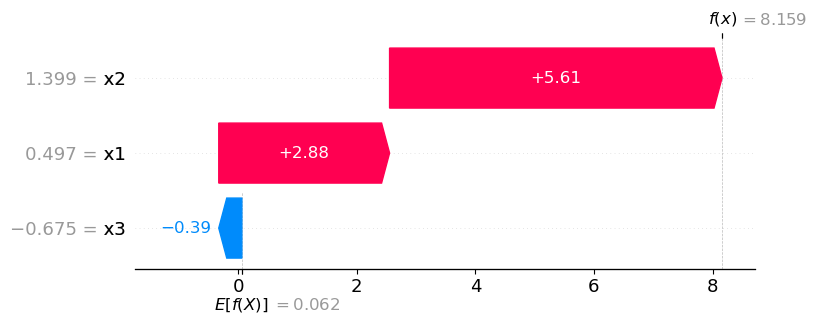


Top interactions for sample 0:
x1 × x2: 1.4420
x1 × x3: -0.0359
x2 × x3: -0.0225


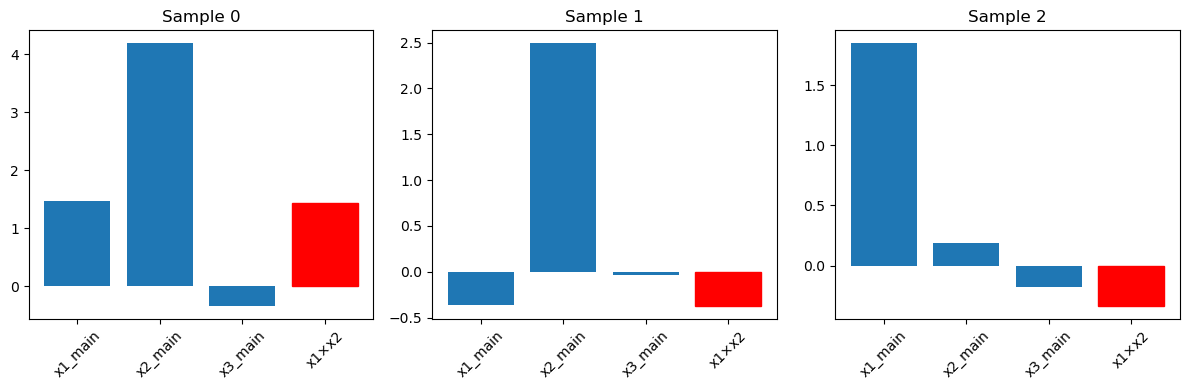

In [15]:
# Visualize interactions
import matplotlib.pyplot as plt

# Fix 1: Use correct data size for plotting
n_samples_for_plot = 10  # Match the size of shap_interaction

# 1. Summary plot for regular SHAP values (not interactions)
shap.summary_plot(shap_values, X[:n_samples_for_plot], max_display=10)

# 2. Dependence plot with interactions - fix the syntax
shap.plots.partial_dependence(
    "x1", model.predict, X[:100], ice=False,
    model_expected_value=True, feature_expected_value=True)

# 3. Use waterfall plot correctly with Explanation object
explanation = explainer(X.iloc[0:1])  # Create proper Explanation object
shap.plots.waterfall(explanation[0])

# 4. Manual interaction analysis (this was correct)
def analyze_interactions(shap_interaction_values, feature_names, sample_idx=0):
    """Analyze feature interactions for a specific sample"""
    n_features = len(feature_names)
    interactions = []
    
    for i in range(n_features):
        for j in range(i+1, n_features):  # Only upper triangle (avoid duplicates)
            interaction_strength = abs(shap_interaction_values[sample_idx, i, j])
            interactions.append({
                'feature_1': feature_names[i],
                'feature_2': feature_names[j], 
                'interaction_value': shap_interaction_values[sample_idx, i, j],
                'abs_strength': interaction_strength
            })
    
    # Sort by interaction strength
    interactions.sort(key=lambda x: x['abs_strength'], reverse=True)
    return interactions

# Analyze strongest interactions
interactions = analyze_interactions(shap_interaction, X.columns, sample_idx=0)
print("\nTop interactions for sample 0:")
for inter in interactions[:3]:
    print(f"{inter['feature_1']} × {inter['feature_2']}: {inter['interaction_value']:.4f}")

# 5. Visualize interaction effects properly
plt.figure(figsize=(12, 4))

# Plot main effects vs interaction effects
for i, sample_idx in enumerate([0, 1, 2]):
    plt.subplot(1, 3, i+1)
    
    # Get diagonal (main effects) and off-diagonal (interactions)
    main_effects = np.diag(shap_interaction[sample_idx])
    x1_x2_interaction = shap_interaction[sample_idx, 0, 1]
    
    bars = plt.bar(['x1_main', 'x2_main', 'x3_main', 'x1×x2'], 
                   [main_effects[0], main_effects[1], main_effects[2], x1_x2_interaction])
    plt.title(f'Sample {sample_idx}')
    plt.xticks(rotation=45)
    
    # Color bars differently
    bars[3].set_color('red')  # Interaction in red

plt.tight_layout()
plt.show()

In [16]:
# Realistic example: House features with interactions
np.random.seed(42)
n_samples = 1000

# Features that might interact
sqft = np.random.uniform(1000, 3000, n_samples)
bedrooms = np.random.choice([2, 3, 4, 5], n_samples)
location_score = np.random.uniform(1, 10, n_samples)  # 1=bad, 10=excellent

# Price with interactions:
# - Larger houses are more valuable in good locations (sqft × location)
# - More bedrooms matter more in larger houses (sqft × bedrooms)
price = (200 * sqft + 
         10000 * bedrooms + 
         5000 * location_score +
         50 * sqft * location_score/10 +  # sqft-location interaction
         2000 * bedrooms * (sqft/1000) +   # bedroom-size interaction
         np.random.normal(0, 10000, n_samples))

X_house = pd.DataFrame({
    'sqft': sqft,
    'bedrooms': bedrooms, 
    'location_score': location_score
})

# Train and analyze
model_house = xgb.XGBRegressor(random_state=42)
model_house.fit(X_house, price)

explainer_house = shap.TreeExplainer(model_house)
shap_interaction_house = explainer_house.shap_interaction_values(X_house[:100])

# Find strongest interactions
interactions_house = analyze_interactions(shap_interaction_house, X_house.columns, 0)
print("\nHouse price interactions:")
for inter in interactions_house:
    print(f"{inter['feature_1']} × {inter['feature_2']}: ${inter['interaction_value']:,.0f}")


House price interactions:
bedrooms × location_score: $-1,781
sqft × location_score: $156
sqft × bedrooms: $-154


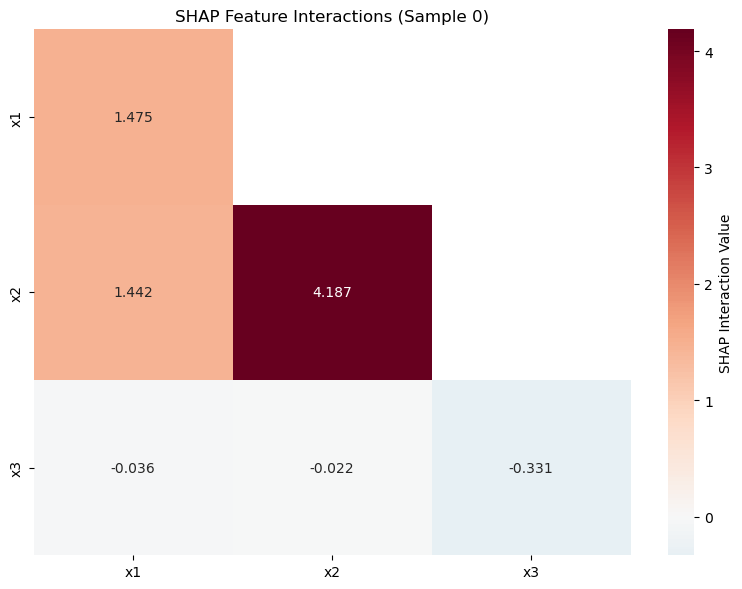

In [24]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_interaction_heatmap(shap_interaction_values, feature_names, sample_idx=0):
    """Create a heatmap of feature interactions for a specific sample"""
    interaction_matrix = shap_interaction_values[sample_idx]
    
    # Create mask for upper triangle (since matrix is symmetric)
    mask = np.triu(np.ones_like(interaction_matrix, dtype=bool), k=1)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(interaction_matrix, 
                annot=True, 
                fmt='.3f',
                xticklabels=feature_names,
                yticklabels=feature_names,
                cmap='RdBu_r',  # Red-Blue diverging colormap
                center=0,       # Center colormap at 0
                mask=mask,      # Hide upper triangle
                cbar_kws={'label': 'SHAP Interaction Value'})
    
    plt.title(f'SHAP Feature Interactions (Sample {sample_idx})')
    plt.tight_layout()
    plt.show()

# Usage
plot_interaction_heatmap(shap_interaction, feature_names=['x1', 'x2', 'x3'])

ValueError: Could not find feature named: feature1

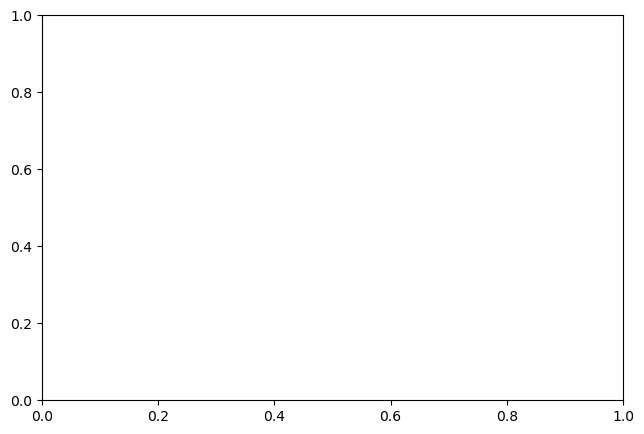

In [25]:
# Built-in SHAP dependence plot for interactions
shap.dependence_plot(
    ('feature1', 'feature2'),  # Feature pair to analyze
    shap_interaction, 
    X,
    display_features=X,
    alpha=0.5
)

# Custom enhanced version
def enhanced_dependence_plot(shap_values, shap_interaction, X, feat1, feat2):
    """Enhanced dependence plot showing individual vs interaction effects"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    feat1_idx = list(X.columns).index(feat1)
    feat2_idx = list(X.columns).index(feat2)
    
    # Individual effect of feature 1
    axes[0].scatter(X[feat1], shap_values[:, feat1_idx], 
                   c=X[feat2], alpha=0.6, cmap='viridis')
    axes[0].set_xlabel(feat1)
    axes[0].set_ylabel(f'SHAP value for {feat1}')
    axes[0].set_title(f'Individual Effect: {feat1}')
    
    # Individual effect of feature 2  
    axes[1].scatter(X[feat2], shap_values[:, feat2_idx], 
                   c=X[feat1], alpha=0.6, cmap='viridis')
    axes[1].set_xlabel(feat2)
    axes[1].set_ylabel(f'SHAP value for {feat2}')
    axes[1].set_title(f'Individual Effect: {feat2}')
    
    # Interaction effect
    interaction_values = shap_interaction[:, feat1_idx, feat2_idx]
    scatter = axes[2].scatter(X[feat1], X[feat2], 
                            c=interaction_values, alpha=0.7, 
                            cmap='RdBu_r', s=50)
    axes[2].set_xlabel(feat1)
    axes[2].set_ylabel(feat2)
    axes[2].set_title(f'Interaction: {feat1} × {feat2}')
    plt.colorbar(scatter, ax=axes[2], label='Interaction SHAP Value')
    
    plt.tight_layout()
    plt.show()

# Usage
enhanced_dependence_plot(shap_values, shap_interaction, X, 'x1', 'x2')

AttributeError: module 'networkx' has no attribute 'draw_edge'

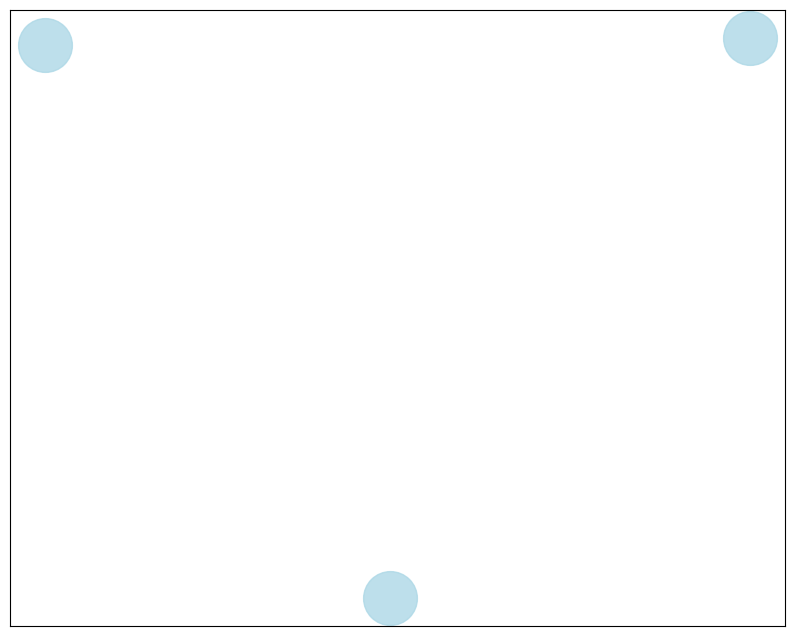

In [26]:
import networkx as nx
from matplotlib.patches import Circle

def plot_interaction_network(shap_interaction_values, feature_names, 
                           threshold=0.01, sample_range=None):
    """Create network graph of feature interactions"""
    if sample_range is None:
        # Average interactions across samples
        avg_interactions = np.mean(np.abs(shap_interaction_values), axis=0)
    else:
        avg_interactions = np.mean(np.abs(shap_interaction_values[sample_range]), axis=0)
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes
    for i, feature in enumerate(feature_names):
        G.add_node(feature)
    
    # Add edges for significant interactions
    edges_added = []
    for i in range(len(feature_names)):
        for j in range(i+1, len(feature_names)):
            interaction_strength = avg_interactions[i, j]
            if interaction_strength > threshold:
                G.add_edge(feature_names[i], feature_names[j], 
                          weight=interaction_strength)
                edges_added.append((feature_names[i], feature_names[j], interaction_strength))
    
    # Plot
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=1500, alpha=0.8)
    
    # Draw edges with thickness proportional to interaction strength
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_weight = max(weights) if weights else 1
    
    for (u, v), weight in zip(edges, weights):
        nx.draw_edge(G, pos, [(u, v)], width=weight/max_weight * 5, 
                    alpha=0.6, edge_color='red')
    
    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title("Feature Interaction Network\n(Edge thickness = Interaction strength)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print strongest interactions
    edges_added.sort(key=lambda x: x[2], reverse=True)
    print("Strongest interactions:")
    for feat1, feat2, strength in edges_added[:5]:
        print(f"{feat1} ↔ {feat2}: {strength:.4f}")

# Usage
plot_interaction_network(shap_interaction, X.columns.to_list())

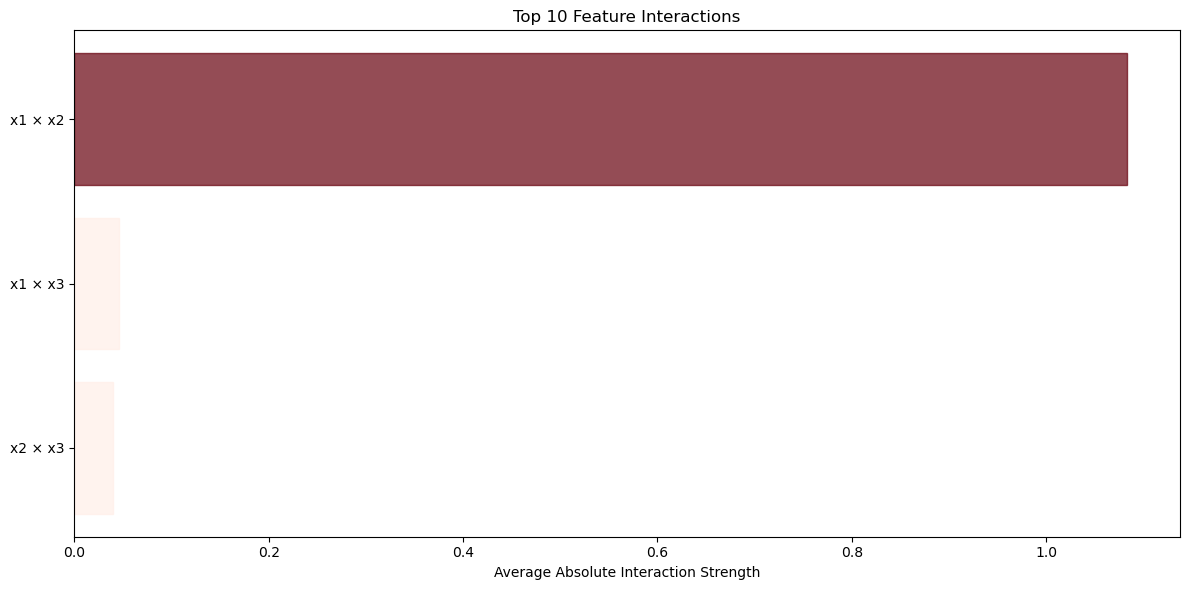

In [27]:
def plot_interaction_ranking(shap_interaction_values, feature_names, top_k=10):
    """Bar plot of strongest average interactions across all samples"""
    
    # Calculate average absolute interaction strength
    avg_abs_interactions = np.mean(np.abs(shap_interaction_values), axis=0)
    
    # Extract unique pairs and their interaction strengths
    interactions = []
    for i in range(len(feature_names)):
        for j in range(i+1, len(feature_names)):
            avg_strength = avg_abs_interactions[i, j]
            interactions.append({
                'pair': f"{feature_names[i]} × {feature_names[j]}",
                'strength': avg_strength,
                'features': (feature_names[i], feature_names[j])
            })
    
    # Sort by strength
    interactions.sort(key=lambda x: x['strength'], reverse=True)
    top_interactions = interactions[:top_k]
    
    # Plot
    pairs = [inter['pair'] for inter in top_interactions]
    strengths = [inter['strength'] for inter in top_interactions]
    
    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(pairs)), strengths, alpha=0.7)
    plt.yticks(range(len(pairs)), pairs)
    plt.xlabel('Average Absolute Interaction Strength')
    plt.title(f'Top {top_k} Feature Interactions')
    plt.gca().invert_yaxis()
    
    # Color bars by strength
    max_strength = max(strengths)
    for i, bar in enumerate(bars):
        bar.set_color(plt.cm.Reds(strengths[i] / max_strength))
    
    plt.tight_layout()
    plt.show()
    
    return top_interactions

# Usage
top_interactions = plot_interaction_ranking(shap_interaction, X.columns.to_list())

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def create_interaction_dashboard(shap_interaction_values, X, feature_names):
    """Create interactive dashboard for SHAP interactions"""
    
    # Calculate average interactions
    avg_interactions = np.mean(shap_interaction_values, axis=0)
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Interaction Heatmap', 'Feature Network', 
                       'Sample-wise Interactions', 'Interaction Distribution'),
        specs=[[{'type': 'heatmap'}, {'type': 'scatter'}],
               [{'type': 'scatter'}, {'type': 'histogram'}]]
    )
    
    # 1. Heatmap
    fig.add_trace(
        go.Heatmap(
            z=avg_interactions,
            x=feature_names,
            y=feature_names,
            colorscale='RdBu',
            zmid=0,
            text=np.round(avg_interactions, 3),
            texttemplate="%{text}",
            textfont={"size": 10}
        ),
        row=1, col=1
    )
    
    # 2. Network-style scatter plot
    interactions_list = []
    for i in range(len(feature_names)):
        for j in range(i+1, len(feature_names)):
            interactions_list.append({
                'x': i, 'y': j,
                'size': abs(avg_interactions[i, j]) * 1000,
                'interaction': avg_interactions[i, j],
                'pair': f"{feature_names[i]} × {feature_names[j]}"
            })
    
    interactions_df = pd.DataFrame(interactions_list)
    fig.add_trace(
        go.Scatter(
            x=interactions_df['x'],
            y=interactions_df['y'],
            mode='markers',
            marker=dict(
                size=interactions_df['size'],
                color=interactions_df['interaction'],
                colorscale='RdBu',
                showscale=False,
                sizemode='diameter',
                sizeref=2.*max(interactions_df['size'])/(40.**2)
            ),
            text=interactions_df['pair'],
            hovertemplate='%{text}<br>Interaction: %{marker.color:.4f}<extra></extra>'
        ),
        row=1, col=2
    )
    
    # Configure layout
    fig.update_layout(
        height=800,
        title_text="SHAP Interaction Analysis Dashboard",
        showlegend=False
    )
    
    fig.show()
    
    return fig

# Usage
dashboard = create_interaction_dashboard(shap_interaction_values, X, feature_names)

NameError: name 'shap_interaction_values' is not defined